# A full analysis for predicting consumer fraud
By Huanwang Yang 
 
The data was obtained from the company (airisDATA)

# The result:  
Classification was performed with accuracy of 0.96 and AUC of 0.77.


# Note: special features to this data set:
Feature engineering made significant improvement in this case. Great improvement was observed after adding the time difference (between purchase_time and signup_time) as one more feature. Some improvement was observed when the countries were added to the data file. 

A special python code was written to merge the two files (one with 151113 lines and another with 138847 lines). If using the traditional looping method, it would take hours to finish, since it would perform ~20981586711 operations. Here I sorted two files and split them into 1000 segments. This only takes ~1 min to finish. 

# =======================================

# The business problem:
Company XYZ is an e-commerce site that sells hand-made clothes. You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. 

# The business  objective:
Build a model to predict whether an activity is fraudulent or not. Explain how different 
assumptions about the cost of false positives vs false negatives would impact the model.

# Understand the data below


Columns from the first file (Fraud_Data.csv): 

user_id : Id of the user. Unique by user    
signup_time : the time when the user created her account (GMT time)        
purchase_time : the time when the user bought the item (GMT time)       
purchase_value : the cost of the item purchased (USD)          
device_id : the device id. You can assume that it is unique by device. I.e., transactions    
            with the same device ID means that the same physical device was used to buy     
source : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly       
                                                   typing the site address on the browser)     
browser : the browser used by the user.     
sex : user sex: Male/Female       
age : age of the user         
user ip_address : user numeric ip address       
class : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0).     


Columns from the second file (IpAddress_to_Country.csv):    

lower_bound_ip_address : the lower bound of the numeric ip address for that country  
upper_bound_ip_address : the upper bound of the numeric ip address for that country   
country : the corresponding country. If a user has an ip address whose value is within 
          the upper and lower bound, then she is based in this country.


"IpAddress_to_Country" - mapping each numeric ip address to its country. 
For each country, it gives a range. If the numeric ip address falls within the range, 
then the ip address belongs to the corresponding country. 


# Answer to some questions:
See bottom!


In [1]:
# import some libraries including the modules (ml_tune_para) that I developed
# Note: The two models must be positioned at the working folder 
import sys
import ml_tune_para as tune
import ml_utility as ut

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from scipy.stats import norm
from sklearn.model_selection import train_test_split

# allow plots to appear in the notebook
%matplotlib inline
plt.rcParams['font.size'] = 14


/Users/hyang/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hyang/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/hyang/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import

In [2]:
#convert from files to data frame and do some checkings
df=pd.read_csv('Fraud_Data.csv')
df0=pd.read_csv('IpAddress_to_Country.csv')
df0=df0.sort_values('lower_bound_ip_address')  #for later use
print 'shape of df and df0=', df.shape, df0.shape 
print 'from the first file=\n', df.head(2)
print '\nfrom the second file=\n', df0.head(2)

shape of df and df0= (151112, 11) (138846, 3)
from the first file=
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  

from the second file=
   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China


In [3]:
# Add countries from pAddress_to_Country.csv to Fraud_Data.csv dataframe
# df and df0 must be sorted!!
def merge_files(df, df0):
    ip0=df0[['lower_bound_ip_address', 'upper_bound_ip_address', 'country']].values

    n=len(ip0)
    bond=[]
    for x in range(0, n, 1000): bond.append(x) #divide for fast calculation
    bond.append(n-1)
    print 'number of segments (for fast calculation) =', len(bond)
    
    cont=[]
    dd=[]
    d1=df['ip_address'].values #already sorted
    nn=0
    for x in d1[:]:
        nn=nn+1
        val=np.nan  #pre assign
        n=0
        for i in range(len(bond)):
            if i==0: continue
            b1, b2 = bond[i-1], bond[i] 
            mini = ip0[b1][0]
            maxi = ip0[b2][0]
            m=b1
            if maxi>= x >=mini : #in the IP boundary
                for y in ip0[b1 : b2]:
                    m=m+1
                    if y[1] >= x >= y[0]:
                        val=ip0[m][2]
                     #   print nn,n, i, m, mini, x, maxi, val
                        n=1
                        break
            if n==1 : break
        cont.append(val)
    df['country']=cont

    return df

df=merge_files(df, df0)

number of segments (for fast calculation) = 140


In [4]:
# When checking the signup_time & purchase_time, it is found that
# the time difference is very correlated with the class (fraud)

#add time difference as one more feature (change to float)
df['signup_time']=pd.to_datetime(df['signup_time'])
df['purchase_time']=pd.to_datetime(df['purchase_time'])
df['dtime'] = (df['purchase_time']-df['signup_time']).astype('timedelta64[h]')


In [5]:
#Print information to understand the data!

print '\nvalue count for class (target)=\n', df['class'].value_counts()
print '\nvalue count for source=\n', df.source.value_counts()
print '\nvalue count for browser=\n', df.browser.value_counts()
print '\nvalue count for sex=\n', df.sex.value_counts()
print '\nvalue count for age=\n', df.age.value_counts().head()
print '\ngroup by sex (mean)=\n', df.groupby('sex').mean()
print '\ngroup by class (mean)=\n', df.groupby('class').mean()

print '\ndescribe of data file Fraud_Data.csv=\n', df.describe()    
print '\ncheck for missing values (percentage)=\n', df.isnull().sum()/len(df) 

print '\nsorted device_id (class=1)=\n', df.loc[df['class']==1, 'device_id'].value_counts().head()
print '\nsorted device_id (class=0)=\n', df.loc[df['class']==0, 'device_id'].value_counts().head()



value count for class (target)=
0    136961
1     14151
Name: class, dtype: int64

value count for source=
SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64

value count for browser=
Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64

value count for sex=
M    88293
F    62819
Name: sex, dtype: int64

value count for age=
32    6666
31    6591
33    6567
30    6392
29    6327
Name: age, dtype: int64

group by sex (mean)=
           user_id  purchase_value        age    ip_address     class  \
sex                                                                     
F    200154.199764       36.892023  33.098887  2.148794e+09  0.091007   
M    200183.023207       36.966215  33.170455  2.154530e+09  0.095523   

           dtime  
sex               
F    1374.900014  
M    1365.718098  

group by class (mean)=
             user_id  purchase_value        age    ip_address        dtime
class              

In [6]:
#visulize the data. separate numerical and catergorical 
df_num=df.select_dtypes(include=[np.number])
df_cat=df.select_dtypes(exclude=[np.number])
    
print 'shape of numerical & categorical dataframe=', df_num.shape, df_cat.shape

shape of numerical & categorical dataframe= (151112, 6) (151112, 7)


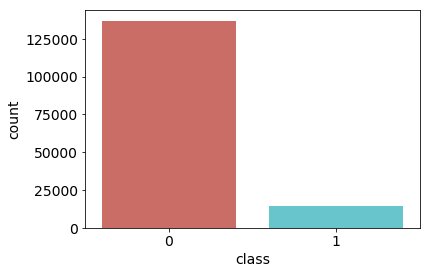

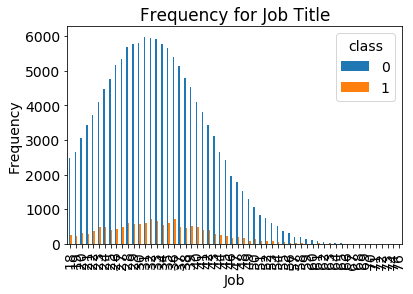

In [7]:
#visulize some data
sns.countplot(data=df_num, x='class', palette='hls')
#plt.savefig('count_plot')
plt.show()

#some visualizations
pd.crosstab(df_num.age, df_num['class']).plot(kind='bar')
plt.title('Frequency for Job Title')
#
plt.xlabel('Job')
plt.ylabel('Frequency')
plt.show()



Plot heatmap to show correlations among the features.


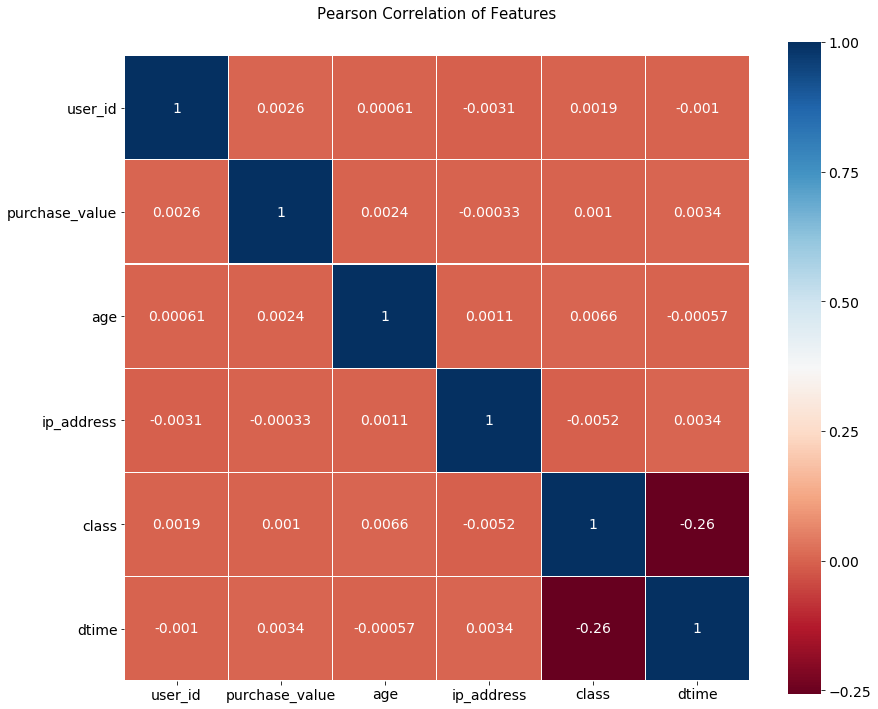

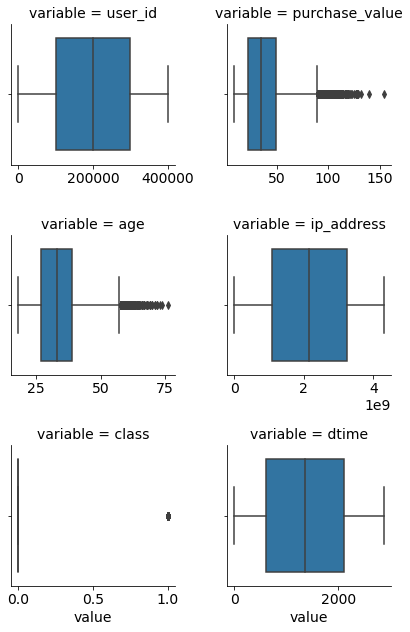

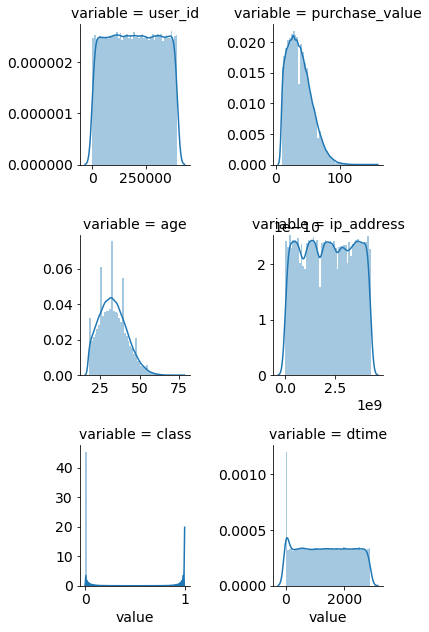

In [8]:
import ml_utility as ut

print '\nPlot heatmap to show correlations among the features.'
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
pcorr=df_num.astype(float).corr()
sns.heatmap(pcorr,linewidths=0.1,vmax=1.0,
        square=True, cmap=colormap, linecolor='white', annot=True)

#more visulizations 
ut.visulization(df_num)


In [9]:
#add dummy variables (need number), drop the first one (duplicated)
cat_vars=['sex','browser','source', 'country']
for var in cat_vars:
    cat_list = pd.get_dummies(df[var], prefix=var, drop_first=True)
    df=df.join(cat_list)
    
print 'total number of columns after get_dummies =', len(df.columns.values)
print 'Averaged values for fraudulent case =\n', df[df['class']==1].mean().sort_values().tail() 
print '\nAveraged values for non-fraudulent case =\n', df[df['class']==0].mean().sort_values().tail()


total number of columns after get_dummies = 200
Averaged values for fraudulent case =
age               3.331828e+01
purchase_value    3.699300e+01
dtime             6.730621e+02
user_id           2.008691e+05
ip_address        2.131918e+09
dtype: float64

Averaged values for non-fraudulent case =
age               3.312236e+01
purchase_value    3.692942e+01
dtime             1.441496e+03
user_id           2.000989e+05
ip_address        2.154235e+09
dtype: float64


In [10]:
# drop some features 

feature_drop=['user_id', 'signup_time', 'purchase_time','device_id',  
              'ip_address','sex','browser','source','class', 'country']

feature=[i for i in df.columns.values if i not in feature_drop] 

X_final=df[feature]
y_final=df['class'] 
print 'shape of the final data =', X_final.shape, y_final.shape

#tmpl=df.mean().sort_values().head(150).keys().values.tolist()
#df.drop(tmpl, axis=1, inplace=True)

shape of the final data = (151112, 190) (151112,)


In [11]:
#Split the data for training and test set 80/20

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20)

print 'Training set (%d) and test set (%d).' %(len(X_train), len(X_test))
print 'shape of X_train & y_train =', X_train.shape, y_train.shape

Training set (120889) and test set (30223).
shape of X_train & y_train = (120889, 190) (120889,)


In [12]:
#Feature selection
import ml_utility as ut

#print X_train.describe()
#X_train, X_test=ut.feature_selection(X_train, X_test, y_train, y_test, 'RFE', 20)
#X_train, X_test=ut.feature_selection(X_train, X_test, y_train, y_test, 'CHI2', 20)
X_train, X_test=ut.feature_selection(X_train, X_test, y_train, y_test, 'model', 7)
print 'After feature selection: shape of X_train & y_train =', X_train.shape, y_train.shape


The shape of Xtrain =  (120889, 190)
The shape of Xtrain_select =  (120889, 9)
The socre of LogisticRegression = 0.9083
After feature selection: shape of X_train & y_train = (120889, 9) (120889,)


In [13]:
#tuning paramters
import ml_tune_para as tune

#tune.auto_tune_classifier(X_train, y_train)
#tune.tune_classifier('RandomForestClassifier', X_train, y_train)
#tune.tune_classifier('LogisticRegression', X_train, y_train)
#tune.tune_classifier('GaussianProcessClassifier', X_train, y_train)
tune.tune_classifier('XGBClassifier', X_train, y_train)
#tune.tune_classifier('GradientBoostingClassifier', X_train, y_train)


Tuning hyperparameters for sklearn.xgboost.XGBClassifier ...
('\nbest_score=', 0.956695811860467)
('best_params=', {})
('best_estimator=', XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='binary:logistic', seed=0, silent=True,
       subsample=1))


Accuracy of RandomForest classifier on test set: 0.96
Classification accuracy= 0.95536511928
Classification AUC_ROC=  0.757971168935
Confusion_matrix=
[[27443     8]
 [ 1341  1431]]

Classification_report=
             precision    recall  f1-score   support

          0       0.95      1.00      0.98     27451
          1       0.99      0.52      0.68      2772

avg / total       0.96      0.96      0.95     30223



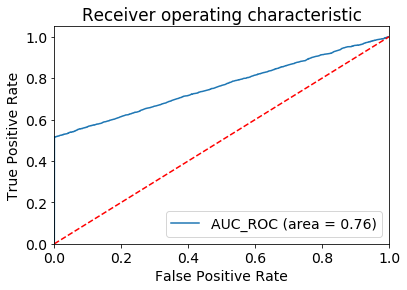

In [14]:
#fitting the model selected from the best training
from  sklearn.ensemble import RandomForestClassifier
from  sklearn.linear_model import LogisticRegression
from  xgboost import XGBClassifier

model= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


model=XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='binary:logistic', seed=0, silent=True,
       subsample=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Accuracy of RandomForest classifier on test set: {:.2f}'.format(
    model.score(X_test, y_test)))

tune.write_result_class(X_test, y_test, y_pred,  model)


In [15]:
# Do cross validation 
from sklearn import model_selection
print 'Perform 10 folder cross validation for the training data.'
kfold = model_selection.KFold(n_splits=10, random_state=7)
cv_results = model_selection.cross_val_score(model,X_train, y_train, cv=kfold, scoring='accuracy')
msg = "\n%s: \n\naccuracy=%f (std=%f)" % (model, cv_results.mean(), cv_results.std())
print(msg)


Perform 10 folder cross validation for the training data.

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='binary:logistic', seed=0, silent=True,
       subsample=1): 

accuracy=0.956696 (std=0.001759)


In [16]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
# store the predicted probabilities for class 1
from sklearn import metrics

y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print '\nSensitivity:', tpr[thresholds > threshold][-1]
    print 'Specificity:', 1 - fpr[thresholds > threshold][-1]

evaluate_threshold(0.5)




Sensitivity: 0.516233766234
Specificity: 0.999708571637



# Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model. 

Sensitivity (also called the true positive rate) measures the proportion of positives that are correctly identified as such.
Specificity (also called the true negative rate) measures the proportion of negatives that are correctly identified as such. 
Sensitivity therefore quantifies the avoiding of false negatives, and specificity does the same for false positives. 
There is usually a trade-off between the two measures which can be adjusted by a threshold according to some business need.  High sensitivity may be needed for this case.


# Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. 

For classification problem, the accuracy and AUC are normally used to judge if the prediction is useful or not. In this case, since the trained data has much lower percentage of fraudulent observations than the non-fraudulent observations, the accuracy may not be very useful. For example, if all the non-fraudulent cases are correctly predicted, but not for the fraudulent, the accuracy value is still very high. Instead, the AUC value is more reliable. 

# What kinds of users are more likely to be classified as at risk? What are their characteristics? 

The data shows users from China have more fraudulent cases than users from other countries.

It is also interesting to note that the time difference between the purchase_time and signup_time  is significantly shorter for the  users who made fraud!

# From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?!

The trained model is kept for late use. Once you have a new data set, you can input it to the model (y_pred = model.predict(X_test)) that was built using the already known observations.  The y_pred will give you 1 (fraudulent) or 0 (non-fraudulent).
